<a href="https://colab.research.google.com/github/yasinsoylu1997/TEZZ2/blob/main/hybr%C4%B1t_my_models_son.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import seaborn as sns
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.metrics import classification_report,confusion_matrix
import keras
import keras.utils
from keras import utils as np_utils
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
#!pip install visualkeras
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import os
!pip install visualkeras
!pip install catboost


In [3]:
labels = ['Lung_Opacity','COVID','Normal','Viral Pneumonia']

In [4]:
X = []
y = []
image_size = 32
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/tezz3/COVID-19_Radiography_Dataset_masked',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X.append(img)
        y.append(i)

        
X = np.array(X)
y = np.array(y)

100%|██████████| 1345/1345 [00:17<00:00, 75.93it/s] 


In [5]:
from imblearn.over_sampling import RandomOverSampler
reshaped_X = X.reshape(X.shape[0],-1)

#oversampling
oversample = RandomOverSampler()
oversampled_X, oversampled_y  = oversample.fit_resample(reshaped_X , y)

# reshaping X back to the first dims
new_X = oversampled_X.reshape(-1,32,32,3)
oversampled_y


array(['Lung_Opacity', 'Lung_Opacity', 'Lung_Opacity', ...,
       'Viral Pneumonia', 'Viral Pneumonia', 'Viral Pneumonia'],
      dtype='<U15')

In [6]:
train_images, test_images,train_labels, test_labels = train_test_split(new_X , oversampled_y , test_size=0.25, random_state=42,shuffle=True)

In [7]:
#train_images=train_images[:1500]
#test_images=test_images[:1500]
#train_labels=train_labels[:1500]
#test_labels=test_labels[:1500]


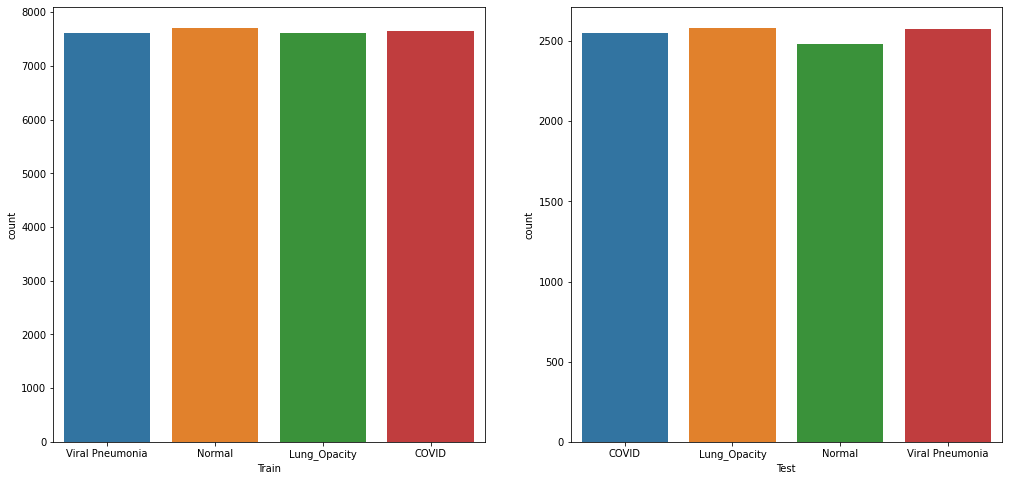

In [8]:
plt.figure(figsize = (17,8));
lis = ['Train', 'Test']
for i,j in enumerate([train_labels, test_labels]):
    plt.subplot(1,2, i+1);
    sns.countplot(x = j);
    plt.xlabel(lis[i])

In [9]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [10]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [11]:
#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [12]:
#One hot encode y values for neural network. 
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [13]:
y_test_one_hot

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [14]:
activation = 'relu'

feature_extractor = Sequential()
feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', input_shape = (32, 32, 3)))
feature_extractor.add(BatchNormalization())

feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())

feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Flatten())

In [15]:
#Add layers for deep learning prediction
x = feature_extractor.output  
x = Dense(128, activation = activation, kernel_initializer = 'he_uniform')(x)
prediction_layer = Dense(4, activation = 'softmax')(x)

In [16]:
# Make a new model combining both feature extractor and x
cnn_model = Model(inputs=feature_extractor.input, outputs=prediction_layer)
cnn_model.compile(optimizer='adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(cnn_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0     

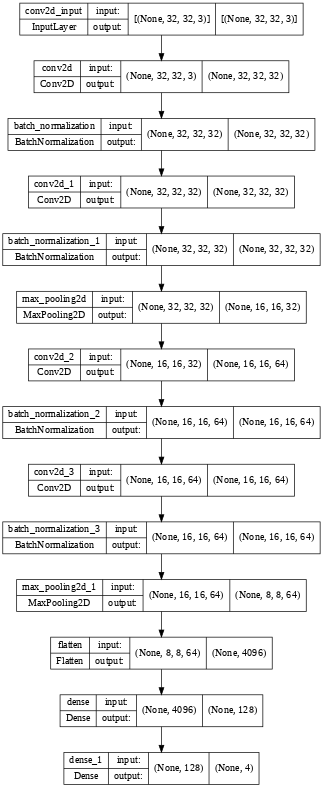

In [17]:
from keras.utils.vis_utils import plot_model

plot_model(cnn_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,dpi=50)

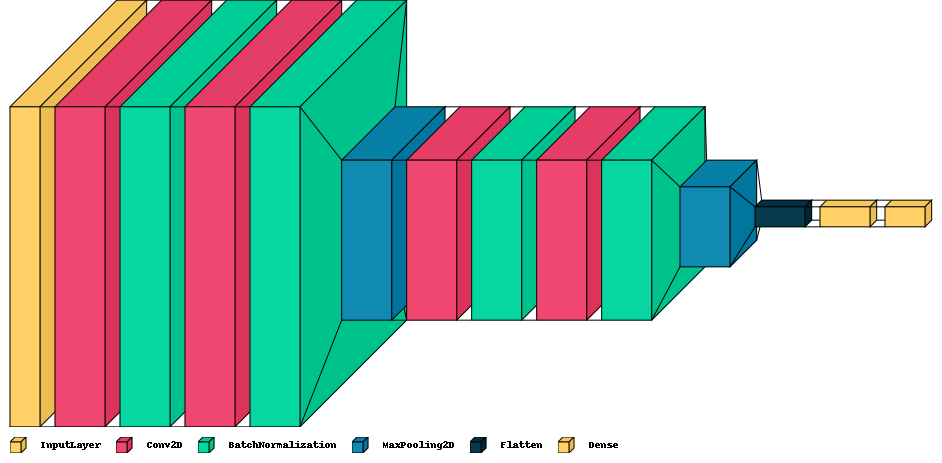

<Figure size 144x144 with 0 Axes>

In [18]:
import visualkeras
from PIL import ImageFont
plt.figure(figsize=(2, 2))
visualkeras.layered_view(cnn_model, legend=True,spacing=15,scale_xy = 10 , scale_z = 10, max_z = 50) 

In [19]:
checkpoint = ModelCheckpoint("cnn.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 4, min_delta = 0.001,mode='auto',verbose=1)
early_stop=tf.keras.callbacks.EarlyStopping( monitor="val_accuracy",patience=4,verbose=1,mode="auto",)

In [20]:
#Train the CNN model
history = cnn_model.fit(x_train, y_train_one_hot, epochs=100, validation_data = (x_test, y_test_one_hot),batch_size=8,callbacks=[checkpoint,reduce_lr,early_stop])

Epoch 1/100
3811/3822 [============================>.] - ETA: 0s - loss: 0.6600 - accuracy: 0.7244
Epoch 1: val_accuracy improved from -inf to 0.77934, saving model to cnn.h5
3822/3822 [==============================] - 42s 7ms/step - loss: 0.6599 - accuracy: 0.7244 - val_loss: 0.5338 - val_accuracy: 0.7793 - lr: 0.0010
Epoch 2/100
3814/3822 [============================>.] - ETA: 0s - loss: 0.4916 - accuracy: 0.8025
Epoch 2: val_accuracy did not improve from 0.77934
3822/3822 [==============================] - 19s 5ms/step - loss: 0.4916 - accuracy: 0.8025 - val_loss: 0.5949 - val_accuracy: 0.7644 - lr: 0.0010
Epoch 3/100
3814/3822 [============================>.] - ETA: 0s - loss: 0.4097 - accuracy: 0.8379
Epoch 3: val_accuracy did not improve from 0.77934
3822/3822 [==============================] - 22s 6ms/step - loss: 0.4096 - accuracy: 0.8379 - val_loss: 0.5269 - val_accuracy: 0.7688 - lr: 0.0010
Epoch 4/100
3813/3822 [============================>.] - ETA: 0s - loss: 0.3391 - ac

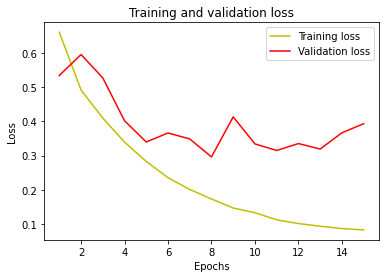

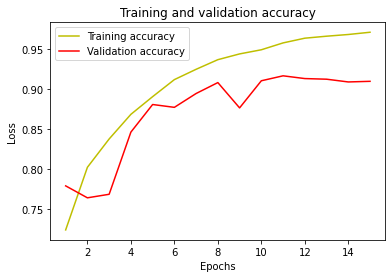

In [21]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


#plot the training and validation accuracy and loss at each epoch
loss = history.history['accuracy']
val_loss = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training accuracy')
plt.plot(epochs, val_loss, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
from keras.models import load_model

cnn_model = load_model('cnn.h5')

In [23]:
prediction_NN = cnn_model.predict(x_test)
prediction_NN = np.argmax(prediction_NN, axis=-1)
prediction_NN = le.inverse_transform(prediction_NN)

[[2400   61   85    4]
 [ 134 2215  222   12]
 [ 162  140 2154   25]
 [   0    2    2 2574]]


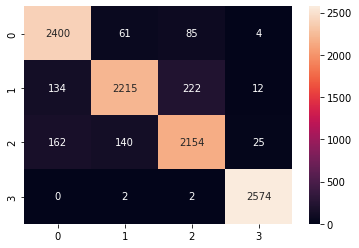

In [24]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, prediction_NN)
print(cm)
sns.heatmap(cm, annot=True,fmt="d")

In [25]:
#Now, let us use features from convolutional network for ML
X_for_model = feature_extractor.predict(x_train) 

In [26]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, X_for_model, y_train)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(y_test, predicted)
    mse = metrics.mean_squared_error(y_test, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, predicted))
    r2_square = metrics.r2_score(y_test, predicted)
    Accuracy= metrics.accuracy_score(y_test,predicted)

    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('Accuracy_mymodel', Accuracy)



    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(y_test, predicted)
    mse = metrics.mean_squared_error(y_test, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, predicted))
    r2_square = metrics.r2_score(y_test, predicted)
    Accuracy= metrics.accuracy_score(y_test,predicted)

    return mae, mse, rmse, r2_square, Accuracy

#  KNeighborsClassifier

In [27]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn_model = knn.fit(X_for_model, y_train)
knn_model

KNeighborsClassifier()

In [28]:
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
predicted = knn_model.predict(X_test_feature)

In [29]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, predicted)

Test set evaluation:
_____________________________________
MAE: 0.21183281004709575
MSE: 0.31544348508634223
RMSE: 0.5616435569703816
R2 Square 0.7489064358369699
Accuracy_mymodel 0.8386970172684458
__________________________________


In [30]:
results_df = pd.DataFrame(data=[["KNeighborsClassifier", *evaluate(y_test, predicted) ]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_mymodel'])
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_mymodel
0,KNeighborsClassifier,0.211833,0.315443,0.561644,0.748906,0.838697


In [31]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      2550
           1       0.82      0.73      0.78      2583
           2       0.76      0.82      0.79      2481
           3       0.97      0.99      0.98      2578

    accuracy                           0.84     10192
   macro avg       0.84      0.84      0.84     10192
weighted avg       0.84      0.84      0.84     10192



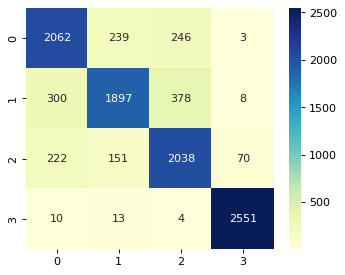

In [32]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,predicted)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# svc

In [33]:
from sklearn.svm import SVC
svm_model = SVC(kernel = "linear")
svm_model = svm_model.fit(X_for_model, y_train)
svm_model

SVC(kernel='linear')

In [34]:
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
predicted = svm_model.predict(X_test_feature)
#Inverse le transform to get original label back. 


print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, predicted)

Test set evaluation:
_____________________________________
MAE: 0.1053767660910518
MSE: 0.15364992150706436
RMSE: 0.3919820423272785
R2 Square 0.8776943945632022
Accuracy_mymodel 0.918563579277865
__________________________________


In [35]:
results_df_2 = pd.DataFrame(data=[["SVC", *evaluate(y_test, predicted)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_mymodel' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_mymodel
0,KNeighborsClassifier,0.211833,0.315443,0.561644,0.748906,0.838697
1,SVC,0.105377,0.153650,0.391982,0.877694,0.918564


In [36]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.87      0.96      0.92      2550
           1       0.89      0.88      0.89      2583
           2       0.92      0.83      0.87      2481
           3       0.99      1.00      1.00      2578

    accuracy                           0.92     10192
   macro avg       0.92      0.92      0.92     10192
weighted avg       0.92      0.92      0.92     10192



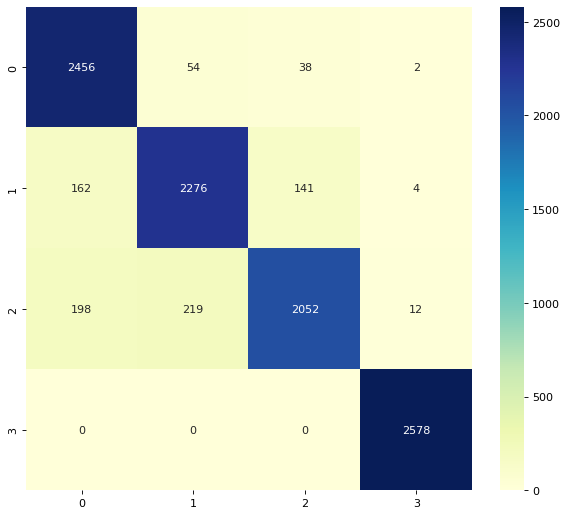

In [37]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(9, 8), dpi=80)
cm = confusion_matrix(y_test,predicted)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# RBF SVC


In [38]:
from sklearn.svm import SVC

svc_model = SVC(kernel = "rbf").fit(X_for_model, y_train)
svc_model = svc_model.fit(X_for_model, y_train)
svc_model

SVC()

In [39]:
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
predicted = svc_model.predict(X_test_feature)
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, predicted)

Test set evaluation:
_____________________________________
MAE: 0.08850078492935635
MSE: 0.12696232339089483
RMSE: 0.35631772814567453
R2 Square 0.898937769198457
Accuracy_mymodel 0.9305337519623234
__________________________________


In [40]:
results_df_2 = pd.DataFrame(data=[["RBF SVC", *evaluate(y_test, predicted) ]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_mymodel'])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_mymodel
0,KNeighborsClassifier,0.211833,0.315443,0.561644,0.748906,0.838697
1,SVC,0.105377,0.153650,0.391982,0.877694,0.918564
2,RBF SVC,0.088501,0.126962,0.356318,0.898938,0.930534


In [41]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.91      0.94      0.93      2550
           1       0.91      0.89      0.90      2583
           2       0.91      0.88      0.90      2481
           3       0.99      1.00      1.00      2578

    accuracy                           0.93     10192
   macro avg       0.93      0.93      0.93     10192
weighted avg       0.93      0.93      0.93     10192



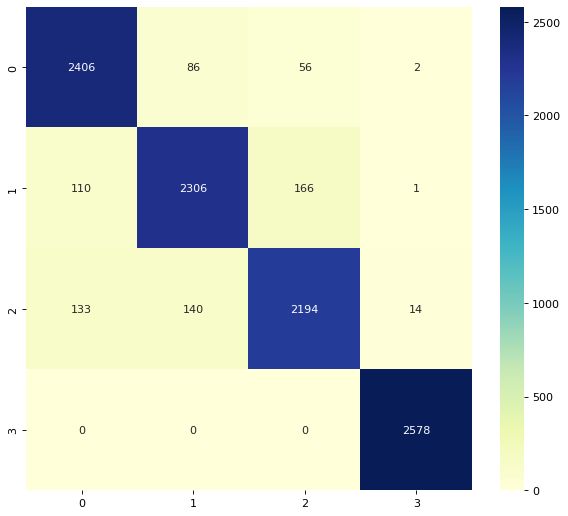

In [42]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(9, 8), dpi=80)
cm = confusion_matrix(y_test,predicted)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# DecisionTreeClassifier

In [43]:
from sklearn.tree import DecisionTreeClassifier
cart_model = DecisionTreeClassifier()
cart_model = cart_model.fit(X_for_model, y_train)
cart_model

DecisionTreeClassifier()

In [44]:
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
predicted = cart_model.predict(X_test_feature)



print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, predicted)

Test set evaluation:
_____________________________________
MAE: 0.18769623233908947
MSE: 0.2807103610675039
RMSE: 0.5298210651413399
R2 Square 0.7765540631196177
Accuracy_mymodel 0.8580259026687598
__________________________________


In [45]:
results_df_2 = pd.DataFrame(data=[["DecisionTreeClassifier", *evaluate(y_test, predicted)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_mymodel' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_mymodel
0,KNeighborsClassifier,0.211833,0.315443,0.561644,0.748906,0.838697
1,SVC,0.105377,0.153650,0.391982,0.877694,0.918564
2,RBF SVC,0.088501,0.126962,0.356318,0.898938,0.930534
3,DecisionTreeClassifier,0.187696,0.280710,0.529821,0.776554,0.858026


In [46]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.81      0.93      0.86      2550
           1       0.83      0.81      0.82      2583
           2       0.84      0.69      0.76      2481
           3       0.95      1.00      0.98      2578

    accuracy                           0.86     10192
   macro avg       0.86      0.86      0.85     10192
weighted avg       0.86      0.86      0.85     10192



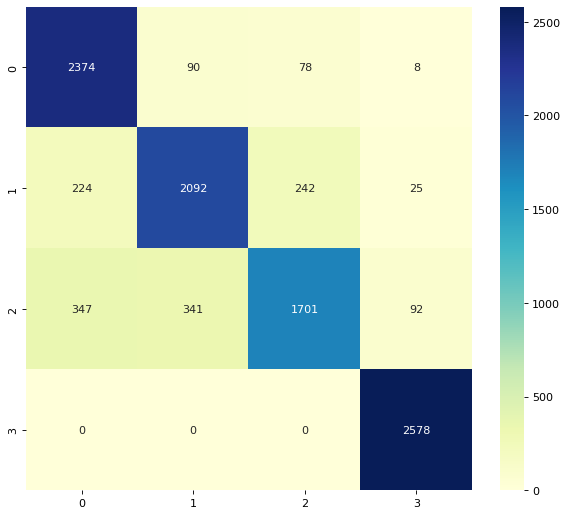

In [47]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(9, 8), dpi=80)
cm = confusion_matrix(y_test,predicted)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# Lojistik regresyon

In [48]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model = lr_model.fit(X_for_model, y_train)
lr_model

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [49]:
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
predicted = lr_model.predict(X_test_feature)



print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, predicted)

Test set evaluation:
_____________________________________
MAE: 0.10616169544740973
MSE: 0.15168759811616955
RMSE: 0.3894709207581094
R2 Square 0.8792564074040298
Accuracy_mymodel 0.9164050235478807
__________________________________


In [50]:
results_df_2 = pd.DataFrame(data=[["LogisticRegression", *evaluate(y_test, predicted)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_mymodel' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_mymodel
0,KNeighborsClassifier,0.211833,0.315443,0.561644,0.748906,0.838697
1,SVC,0.105377,0.153650,0.391982,0.877694,0.918564
2,RBF SVC,0.088501,0.126962,0.356318,0.898938,0.930534
3,DecisionTreeClassifier,0.187696,0.280710,0.529821,0.776554,0.858026
4,LogisticRegression,0.106162,0.151688,0.389471,0.879256,0.916405


In [51]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      2550
           1       0.88      0.88      0.88      2583
           2       0.91      0.83      0.87      2481
           3       0.99      1.00      0.99      2578

    accuracy                           0.92     10192
   macro avg       0.92      0.92      0.92     10192
weighted avg       0.92      0.92      0.92     10192



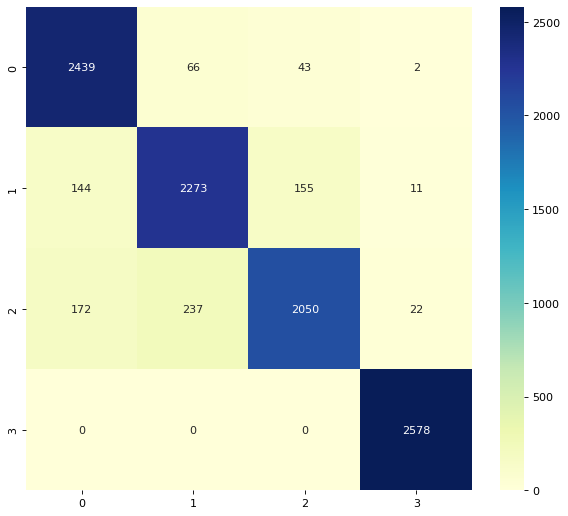

In [52]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(9, 8), dpi=80)
cm = confusion_matrix(y_test,predicted)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# SGDClassifier

In [53]:
from sklearn.linear_model import SGDClassifier

SGD_model = SGDClassifier()
SGD_model = SGD_model.fit(X_for_model, y_train)
SGD_model

SGDClassifier()

In [54]:
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
predicted = SGD_model.predict(X_test_feature)



print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, predicted)

Test set evaluation:
_____________________________________
MAE: 0.10478806907378337
MSE: 0.14972527472527472
RMSE: 0.3869435032731196
R2 Square 0.8808184202448573
Accuracy_mymodel 0.9175824175824175
__________________________________


In [55]:
results_df_2 = pd.DataFrame(data=[["SGDClassifier", *evaluate(y_test, predicted)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_mymodel' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_mymodel
0,KNeighborsClassifier,0.211833,0.315443,0.561644,0.748906,0.838697
1,SVC,0.105377,0.153650,0.391982,0.877694,0.918564
2,RBF SVC,0.088501,0.126962,0.356318,0.898938,0.930534
3,DecisionTreeClassifier,0.187696,0.280710,0.529821,0.776554,0.858026
4,LogisticRegression,0.106162,0.151688,0.389471,0.879256,0.916405
5,SGDClassifier,0.104788,0.149725,0.386944,0.880818,0.917582


In [56]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      2550
           1       0.88      0.89      0.88      2583
           2       0.91      0.82      0.87      2481
           3       0.99      1.00      0.99      2578

    accuracy                           0.92     10192
   macro avg       0.92      0.92      0.92     10192
weighted avg       0.92      0.92      0.92     10192



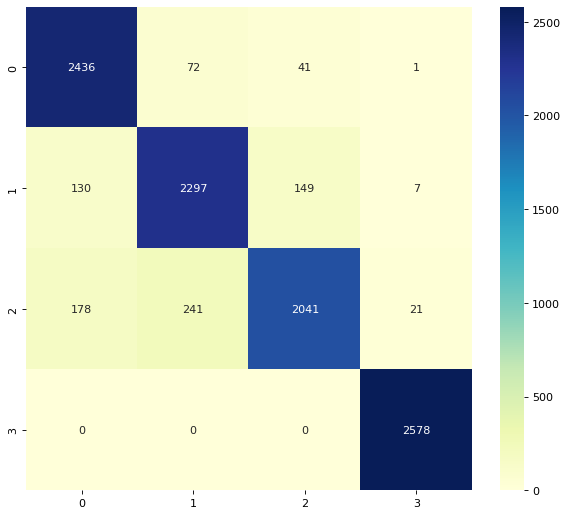

In [57]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(9, 8), dpi=80)
cm = confusion_matrix(y_test,predicted)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# GradientBoostingClassifier

In [58]:
from sklearn.ensemble import GradientBoostingClassifier

GBC_model = GradientBoostingClassifier()
GBC_model = GBC_model.fit(X_for_model, y_train)
GBC_model

GradientBoostingClassifier()

In [59]:
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
predicted = GBC_model.predict(X_test_feature)



print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, predicted)

Test set evaluation:
_____________________________________
MAE: 0.18906985871271587
MSE: 0.28385007849293564
RMSE: 0.5327758238630349
R2 Square 0.7740548425742937
Accuracy_mymodel 0.8576334379905809
__________________________________


In [60]:
results_df_2 = pd.DataFrame(data=[["GradientBoostingClassifier", *evaluate(y_test, predicted)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_mymodel' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_mymodel
0,KNeighborsClassifier,0.211833,0.315443,0.561644,0.748906,0.838697
1,SVC,0.105377,0.153650,0.391982,0.877694,0.918564
2,RBF SVC,0.088501,0.126962,0.356318,0.898938,0.930534
3,DecisionTreeClassifier,0.187696,0.280710,0.529821,0.776554,0.858026
4,LogisticRegression,0.106162,0.151688,0.389471,0.879256,0.916405
5,SGDClassifier,0.104788,0.149725,0.386944,0.880818,0.917582
6,GradientBoostingClassifier,0.189070,0.283850,0.532776,0.774055,0.857633


In [61]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.82      0.81      0.81      2550
           1       0.83      0.81      0.82      2583
           2       0.81      0.81      0.81      2481
           3       0.97      1.00      0.98      2578

    accuracy                           0.86     10192
   macro avg       0.86      0.86      0.86     10192
weighted avg       0.86      0.86      0.86     10192



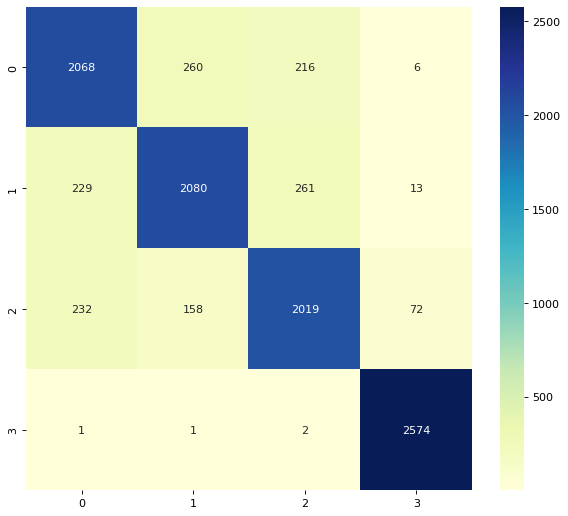

In [62]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(9, 8), dpi=80)
cm = confusion_matrix(y_test,predicted)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# LGBMClassifier

In [63]:
from lightgbm import LGBMClassifier

LGBM_model = LGBMClassifier()
LGBM_model = LGBM_model.fit(X_for_model, y_train)
LGBM_model

LGBMClassifier()

In [64]:
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
predicted = LGBM_model.predict(X_test_feature)



print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, predicted)

Test set evaluation:
_____________________________________
MAE: 0.11420722135007849
MSE: 0.1683673469387755
RMSE: 0.41032590332414487
R2 Square 0.8659792982569955
Accuracy_mymodel 0.9125784929356358
__________________________________


In [65]:
results_df_2 = pd.DataFrame(data=[["LGBMClassifier", *evaluate(y_test, predicted)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_mymodel' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_mymodel
0,KNeighborsClassifier,0.211833,0.315443,0.561644,0.748906,0.838697
1,SVC,0.105377,0.153650,0.391982,0.877694,0.918564
2,RBF SVC,0.088501,0.126962,0.356318,0.898938,0.930534
3,DecisionTreeClassifier,0.187696,0.280710,0.529821,0.776554,0.858026
4,LogisticRegression,0.106162,0.151688,0.389471,0.879256,0.916405
5,SGDClassifier,0.104788,0.149725,0.386944,0.880818,0.917582
6,GradientBoostingClassifier,0.189070,0.283850,0.532776,0.774055,0.857633
7,LGBMClassifier,0.114207,0.168367,0.410326,0.865979,0.912578


In [66]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90      2550
           1       0.90      0.87      0.89      2583
           2       0.88      0.85      0.87      2481
           3       0.98      1.00      0.99      2578

    accuracy                           0.91     10192
   macro avg       0.91      0.91      0.91     10192
weighted avg       0.91      0.91      0.91     10192



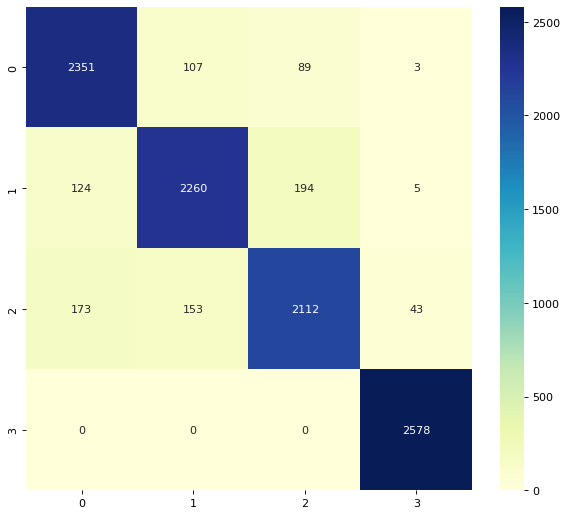

In [67]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(9, 8), dpi=80)
cm = confusion_matrix(y_test,predicted)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# XGBClassifier

In [68]:
from xgboost.sklearn import XGBClassifier

XGBC_model = XGBClassifier()
XGBC_model = XGBC_model.fit(X_for_model, y_train)
XGBC_model

XGBClassifier(objective='multi:softprob')

In [69]:
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
predicted = XGBC_model.predict(X_test_feature)



print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, predicted)

Test set evaluation:
_____________________________________
MAE: 0.21683673469387754
MSE: 0.3292778649921507
RMSE: 0.5738273825743685
R2 Square 0.7378942453091357
Accuracy_mymodel 0.8380102040816326
__________________________________


In [70]:
results_df_2 = pd.DataFrame(data=[["XGBClassifier", *evaluate(y_test, predicted)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_mymodel' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_mymodel
0,KNeighborsClassifier,0.211833,0.315443,0.561644,0.748906,0.838697
1,SVC,0.105377,0.153650,0.391982,0.877694,0.918564
2,RBF SVC,0.088501,0.126962,0.356318,0.898938,0.930534
3,DecisionTreeClassifier,0.187696,0.280710,0.529821,0.776554,0.858026
4,LogisticRegression,0.106162,0.151688,0.389471,0.879256,0.916405
5,SGDClassifier,0.104788,0.149725,0.386944,0.880818,0.917582
6,GradientBoostingClassifier,0.189070,0.283850,0.532776,0.774055,0.857633
7,LGBMClassifier,0.114207,0.168367,0.410326,0.865979,0.912578
8,XGBClassifier,0.216837,0.329278,0.573827,0.737894,0.838010


In [71]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79      2550
           1       0.82      0.78      0.80      2583
           2       0.78      0.80      0.79      2481
           3       0.95      0.99      0.97      2578

    accuracy                           0.84     10192
   macro avg       0.84      0.84      0.84     10192
weighted avg       0.84      0.84      0.84     10192



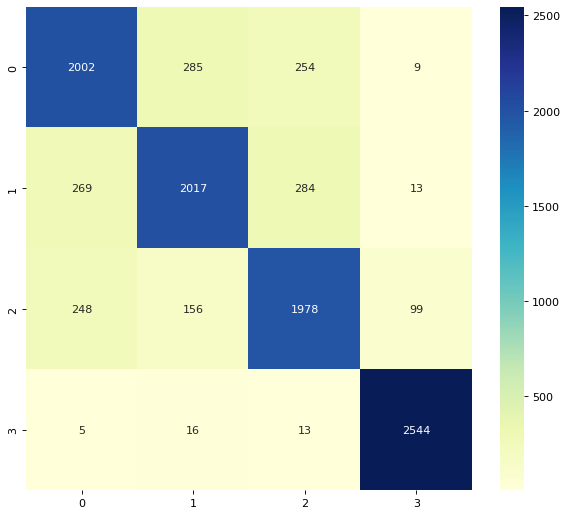

In [72]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(9, 8), dpi=80)
cm = confusion_matrix(y_test,predicted)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# RandomForestClassifier

In [73]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model = rf_model.fit(X_for_model, y_train)
rf_model

RandomForestClassifier()

In [74]:
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
predicted = rf_model.predict(X_test_feature)

In [75]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, predicted)

Test set evaluation:
_____________________________________
MAE: 0.0967425431711146
MSE: 0.1379513343799058
RMSE: 0.3714180049215517
R2 Square 0.8901904972898227
Accuracy_mymodel 0.923861852433281
__________________________________


In [76]:
results_df_2 = pd.DataFrame(data=[["RandomForestClassifier", *evaluate(y_test, predicted)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_mymodel' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_mymodel
0,KNeighborsClassifier,0.211833,0.315443,0.561644,0.748906,0.838697
1,SVC,0.105377,0.153650,0.391982,0.877694,0.918564
2,RBF SVC,0.088501,0.126962,0.356318,0.898938,0.930534
3,DecisionTreeClassifier,0.187696,0.280710,0.529821,0.776554,0.858026
4,LogisticRegression,0.106162,0.151688,0.389471,0.879256,0.916405
5,SGDClassifier,0.104788,0.149725,0.386944,0.880818,0.917582
6,GradientBoostingClassifier,0.189070,0.283850,0.532776,0.774055,0.857633
7,LGBMClassifier,0.114207,0.168367,0.410326,0.865979,0.912578
8,XGBClassifier,0.216837,0.329278,0.573827,0.737894,0.838010
9,RandomForestClassifier,0.096743,0.137951,0.371418,0.890190,0.923862


In [77]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      2550
           1       0.90      0.90      0.90      2583
           2       0.88      0.87      0.87      2481
           3       0.98      1.00      0.99      2578

    accuracy                           0.92     10192
   macro avg       0.92      0.92      0.92     10192
weighted avg       0.92      0.92      0.92     10192



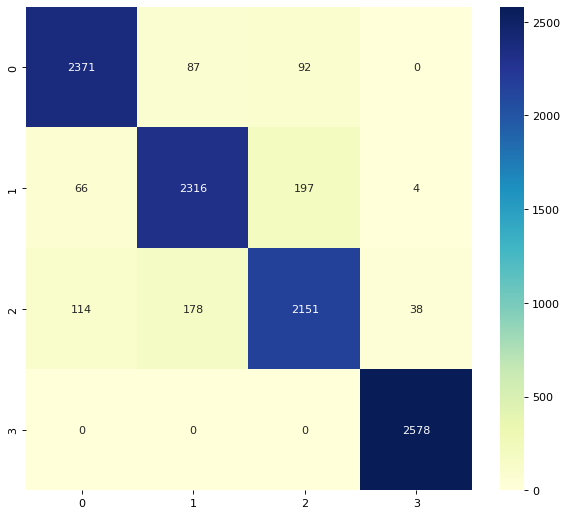

In [78]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(9, 8), dpi=80)
cm = confusion_matrix(y_test,predicted)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# GaussianNB

In [79]:
from sklearn.naive_bayes import GaussianNB


GB_model = GaussianNB()
GB_model = GB_model.fit(X_for_model, y_train)
GB_model

GaussianNB()

In [80]:
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
predicted = GB_model.predict(X_test_feature)

In [81]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, predicted)

Test set evaluation:
_____________________________________
MAE: 0.39374018838304553
MSE: 0.6188186813186813
RMSE: 0.7866502916281677
R2 Square 0.5074192506450295
Accuracy_mymodel 0.7133045525902669
__________________________________


In [82]:
results_df_2 = pd.DataFrame(data=[["GaussianNB", *evaluate(y_test, predicted)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_mymodel' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_mymodel
0,KNeighborsClassifier,0.211833,0.315443,0.561644,0.748906,0.838697
1,SVC,0.105377,0.153650,0.391982,0.877694,0.918564
2,RBF SVC,0.088501,0.126962,0.356318,0.898938,0.930534
3,DecisionTreeClassifier,0.187696,0.280710,0.529821,0.776554,0.858026
4,LogisticRegression,0.106162,0.151688,0.389471,0.879256,0.916405
5,SGDClassifier,0.104788,0.149725,0.386944,0.880818,0.917582
6,GradientBoostingClassifier,0.189070,0.283850,0.532776,0.774055,0.857633
7,LGBMClassifier,0.114207,0.168367,0.410326,0.865979,0.912578
8,XGBClassifier,0.216837,0.329278,0.573827,0.737894,0.838010
9,RandomForestClassifier,0.096743,0.137951,0.371418,0.890190,0.923862


In [83]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.69      0.47      0.56      2550
           1       0.64      0.69      0.66      2583
           2       0.63      0.74      0.68      2481
           3       0.90      0.94      0.92      2578

    accuracy                           0.71     10192
   macro avg       0.71      0.71      0.71     10192
weighted avg       0.71      0.71      0.71     10192



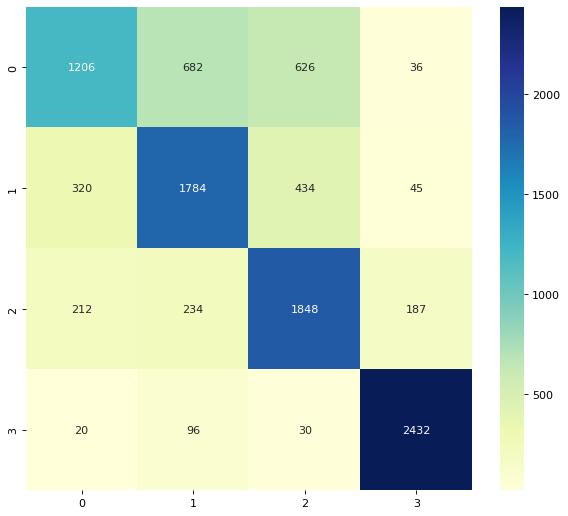

In [84]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(9, 8), dpi=80)
cm = confusion_matrix(y_test,predicted)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

In [85]:
modeller = [rf_model,GB_model,XGBC_model,LGBM_model,GBC_model,SGD_model,lr_model,cart_model,svc_model,svm_model,knn_model]

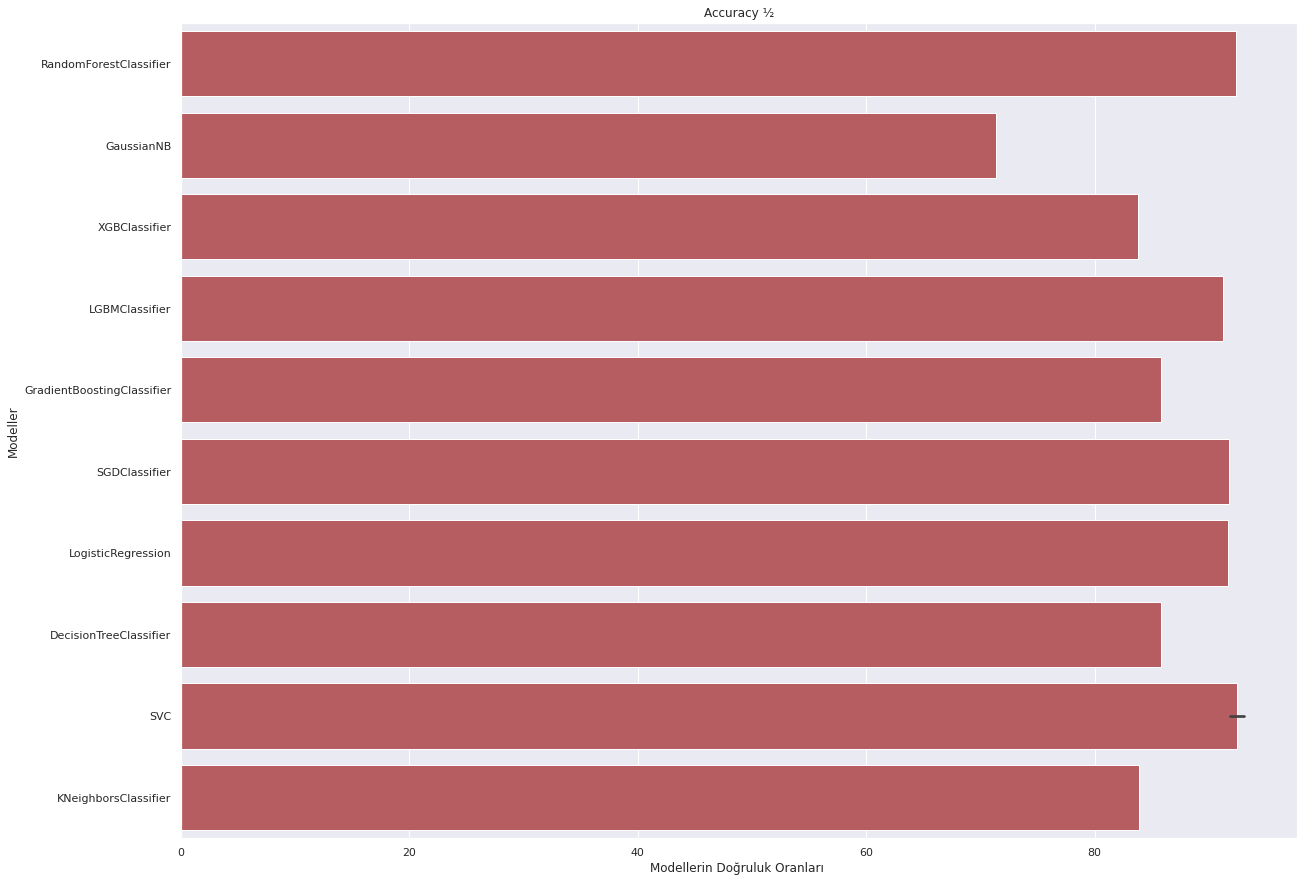

In [87]:
from sklearn.metrics import accuracy_score
sonuc = []

sonuclar = pd.DataFrame(columns= ["Modeller","Accuracy"])

for model in modeller:
    isimler = model.__class__.__name__
    y_pred = model.predict(X_test_feature)
    dogruluk = accuracy_score(y_test, y_pred)    
    sonuc = pd.DataFrame([[isimler, dogruluk*100]], columns= ["Modeller","Accuracy"])
    sonuclar = sonuclar.append(sonuc)
    
sns.set(rc={'figure.figsize':(20,15)})
sns.barplot(x= 'Accuracy', y = 'Modeller', data=sonuclar, color="r")
plt.xlabel('Modellerin Doğruluk Oranları ')
plt.title('Accuracy ½');  

In [ ]:
results_df